random forest score: 0.7909309791332263
log regression score: 0.5686195826645265
cross entropy(CE) score: 0.7560917190555344
Calibrated random forest CE score: 0.6451699400439477
Calibrated random forest score: 0.7724719101123596


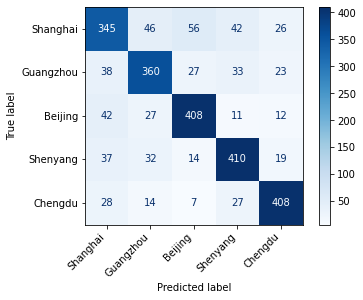

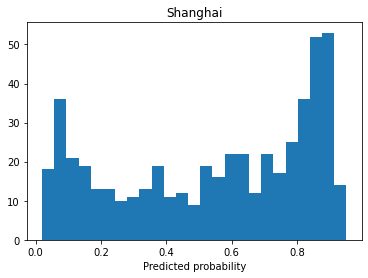

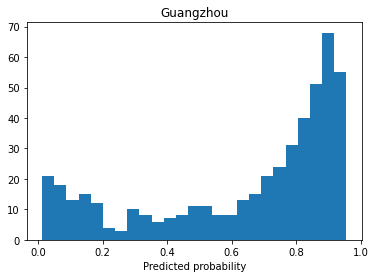

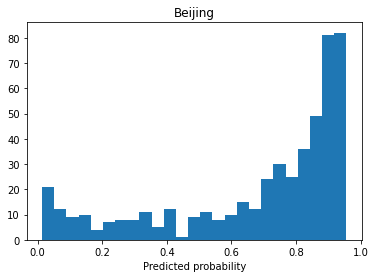

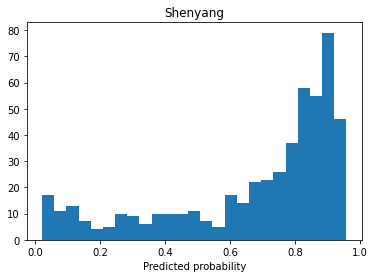

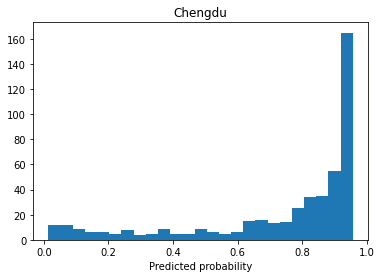

Transfer to  Shanghai
random forest score: 0.4454110946048814
Neural net score: 0.4624743742681362
Transfer to  Guangzhou
random forest score: 0.9371807171672122
Neural net score: 0.4536985698219026
Transfer to  Beijing
random forest score: 0.988230701429837
Neural net score: 0.34423122011110274
Transfer to  Shenyang
random forest score: 0.9982495596068496
Neural net score: 0.5329621293658406
Transfer to  Chengdu
random forest score: 0.9997608856867314
Neural net score: 0.6770328831248509


In [106]:
## small investigation into transfer learning and the PM2.5 dataset
import pandas as pd
import numpy as np
import sys
import os
import glob
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.linear_model as sklinear
import sklearn.ensemble as sklens
import sklearn.metrics as metr
import sklearn.calibration as cal
import matplotlib.pyplot as plt
import sklearn.neural_network as nn

def wind_direction_to_int(cbwd):
        if cbwd=="cv":
            return 0
        elif cbwd=="N":
            return 1
        elif cbwd=="NW":
            return 2
        elif cbwd=="W":
            return 3
        elif cbwd=="SW":
            return 4
        elif cbwd=="S":
            return 5
        elif cbwd=="SE":
            return 6
        elif cbwd=="E":
            return 7
        elif cbwd=="NE":
            return 8

def make_data_into_vector(row):
    #"cbwd","year","month","day","season","DEWP","TEMP","HUMI","PRES","Iws","precipitation","Iprec"
    x=np.zeros(12)
    x[0] = row['cbwd']
    x[1] = row['year']
    x[2] = row['month']
    x[3] = row['day']
    x[4] = row['season']
    x[5] = row['DEWP']
    x[6] = row['TEMP']
    x[7] = row['HUMI']
    x[8] = row['PRES']
    x[9] = row['Iws']
    x[10] = row['precipitation']
    x[11] = row['Iprec']
    return x
    
'''
No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
season: season of data in this row
PM_{placename}: PM2.5 concentration (ug/m^3)
DEWP: Dew Point (Celsius Degree)
TEMP: Temperature (Celsius Degree)
HUMI: Humidity (%)
PRES: Pressure (hPa)
cbwd: Combined wind direction
Iws: Cumulated wind speed (m/s)
precipitation: hourly precipitation (mm)
Iprec: Cumulated precipitation (mm)
'''

files = glob.glob("data/*.csv")

# load every csv into a dataframe
dfs = [pd.read_csv(f) for f in files]
"""
read in this order
------------------
data/ShanghaiPM20100101_20151231.csv
data/GuangzhouPM20100101_20151231.csv
data/BeijingPM20100101_20151231.csv
data/ShenyangPM20100101_20151231.csv
data/ChengduPM20100101_20151231.csv
"""
cities=["Shanghai","Guangzhou","Beijing","Shenyang","Chengdu"]

years=[2010,2011,2012,2013,2014,2015]
nonfeatures=["No","cbwd","year","month","day","hour","season"]
features2=["DEWP","TEMP","HUMI","PRES","Iws","precipitation","Iprec"]
features3=['PM_Dongsi','PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post']
ylabels=["PM2.5 concentration (ug/m^3)","PM2.5 concentration (ug/m^3)","PM2.5 concentration (ug/m^3)","Dew Point ($^{\circ{}}C$)","Temperature ($^{\circ{}}C$)","Humidity (%)"
         ,"Pressure (hPa)","Cumulated wind speed (m/s)","hourly precipitation (mm)",
         "Cumulated precipitation (mm)"]
ylabels2=["Dew Point ($^{\circ{}}C$)","Temperature ($^{\circ{}}C$)","Humidity (%)"
         ,"Pressure (hPa)","Cumulated wind speed (m/s)","hourly precipitation (mm)",
         "Cumulated precipitation (mm)"]







## remove outliers (mainly concerns Beijing and Chengdu)
for i in range(5):
        df=dfs[i]
        features=df.columns
        # fills NaN's with 0
        df=df.fillna(0)
        
        # remove datapoints outside 3 std
        for f in features:
            if f not in nonfeatures:    
                df=df[np.abs(df.loc[:,f]-df.loc[:,f].mean())<=(3*df.loc[:,f].std())]
                dfs[i]=df
        


## only take 15:00 every day
for i in range(5):
    df=dfs[i]
    dfs[i]=df[df["hour"]==15]
    
      

### make average of all PM stations in each city
for j in range(5):
    df=dfs[j]
    df["PM_average"]=df.loc[:, df.columns.str.startswith('PM')].mean(axis=1)
    dfs[j]=df   
    
    
# change the winddirection to be integers    
for i in range(5):
    df=dfs[i]
    df["cbwd"]=df["cbwd"].apply(lambda x: wind_direction_to_int(x))
    dfs[i]=df

    
    ## normalise values here, should we do it another way?
for i in range(5):
    df=dfs[i]
    norm_df=(df-df.min())/(df.max()-df.min())
    dfs[i]=norm_df


##########################################    
### Train classifier to predict city  ####
##########################################

x_arrays = []
outcomes = []
for j in range(5):
    df=dfs[j]
    for index, row in df.iterrows():
            x = make_data_into_vector(row)
            x_arrays.append(x)
            outcomes.append(j)

X = np.stack(x_arrays, axis=0)
y = np.array(outcomes)

## split all dataframes into train and test set
X_train,X_test,y_train,y_test =train_test_split(X,y)

     

random_forest = sklens.RandomForestClassifier().fit(X_train, y_train)
score_rf = random_forest.score(X_test, y_test)
print('random forest score:', score_rf)
#log_regressor = sklinear.LogisticRegression(random_state=1, max_iter=200).fit(X_train, y_train)
log_regressor = sklinear.LogisticRegression(multi_class="ovr").fit(X_train, y_train)
score_log = log_regressor.score(X_test, y_test)
print('log regression score:',score_log)
#print('log cv score', np.mean(cross_val_score(sklinear.LogisticRegression(multi_class="ovr"), X, y, cv=10)))   
#print('rf cv score', np.mean(cross_val_score(sklens.RandomForestClassifier(), X, y, cv=10)))


## trying calibration, take as large a portion for validation as training
L=len(X_test)
X_valid=X_train[:L]
y_valid=y_train[:L]
X_train2=X_train[L:]
y_train2=y_train[L:]
random_forest2=sklens.RandomForestClassifier().fit(X_train2, y_train2)
rf=sklens.RandomForestClassifier().fit(X_train2, y_train2)
clf_probs=rf.predict_proba(X_test)
score = metr.log_loss(y_test, clf_probs)
print("cross entropy(CE) score:",score)

sig_clf = cal.CalibratedClassifierCV(random_forest2, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
#print(sig_clf_probs)
sig_score = metr.log_loss(y_test, sig_clf_probs)
print("Calibrated random forest CE score:",sig_score)
print("Calibrated random forest score:",sig_clf.score(X_test, y_test))



disp = metr.plot_confusion_matrix(random_forest2, X_test, y_test,
                                 display_labels=cities,
                                 cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.show()


## do calibration plots; i.e prob vs rate

for j in range(5):
    L2=len(y_test)
    A=np.zeros(L2)
    for idx,k in enumerate(y_test):
        if (k==j):
            A[idx]=1
    data=[]
    
    for ind,i in enumerate(A):
        if i==1:
            data.append(sig_clf_probs[ind,j])
            #data.append(clf_probs[ind,j])
    fig,ax = plt.subplots(1,1)
    ax.set_title(str(cities[j]))
    ax.set_xlabel("Predicted probability")
    
    ax.hist(data,bins=25)
    plt.show()
# Plot changes in predicted probabilities via arrows
# does not really work for visualising 5 label classification
#plt.figure()
#colors = ["r", "g", "b", "m", "y"]
#for i in range(clf_probs.shape[0]):
#    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
#              sig_clf_probs[i, 0] - clf_probs[i, 0],
#              sig_clf_probs[i, 1] - clf_probs[i, 1],
#              color=colors[y_test[i]], head_width=1e-3)




### make new classifier which instead learns from all other cities but predicts PM- conc. in new city


##########################################    
## Train classifier to predict PM conc. ##
##########################################

x_arrays = []
outcomes = []
for k in range(5): ##### train on all but one and try to transfer 
    for j in range(5):
        if j==k:
            continue
        df=dfs[j]
        for index, row in df.iterrows():
                x = make_data_into_vector(row)
                x_arrays.append(x)
                outcomes.append(df["PM_average"][index])

    X = np.stack(x_arrays, axis=0)
    y = np.array(outcomes)
    
    ## make the target set
    x_arrays2 = []
    outcomes2 = []
    df=dfs[k]
    for index, row in df.iterrows():
                x = make_data_into_vector(row)
                x_arrays2.append(x)
                outcomes2.append(df["PM_average"][index])
    X_target = np.stack(x_arrays2, axis=0)
    y_target = np.array(outcomes2)
    
    ## split all dataframes into train and test set
    #X_train,X_test,y_train,y_test =train_test_split(X,y)

    ### RF regressor
    random_forest = sklens.RandomForestRegressor().fit(X, y)
    print("Transfer to ",cities[k])

    #random_forest = sklens.RandomForestClassifier().fit(X_train, y_train)
    score_rf = random_forest.score(X_target, y_target)
    print('random forest score:', score_rf)



    ### NN regressor
    neural_network=nn.MLPRegressor().fit(X,y)
    score_nn = neural_network.score(X_target, y_target)
    print('Neural net score:', score_nn)

    #### predict how often we are at an unsafe level, unsafe defined as meadian of known distr of PM conc.